# Initial Data Analysis for $M_{Pro}$ Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# import rdkit components
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem, MolToSmiles
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
import os
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

## Functions of Interest:


In [2]:
def check_substructure(mol_list, substructure_SMARTS):
	"""
	Check whether a SMARTS pattern of a substructure is present in a set of molecules and identify where the substructure is present and where it is not present.
	:param mol_list: A list of SMILES
	:param substructure_SMARTS: SMARTS pattern for recognizing a specific substructure
	:return: selected_mol_list: A list of SMILES of molecules containing the substructure.
	"""
	molecule_list = [Chem.MolFromSmiles(x) for x in mol_list]
	sub_structure = Chem.MolFromSmarts(substructure_SMARTS)
	selected_molecules_list = []
	unselected_molecules_list = []
	for molecule in molecule_list:
		if molecule.HasSubstructMatch(sub_structure):
			selected_molecules_list.append(Chem.MolToSmiles(molecule))
		else:
			unselected_molecules_list.append(Chem.MolToSmiles(molecule))
	return selected_molecules_list, unselected_molecules_list

In [3]:
def standardize_and_remove_duplicates(smiles_list):
    """
    Standardize SMILES patterns and remove duplicates from a list.
    :param smiles_list: A list of SMILE strings
    :return: A list of unique, standardized SMILE strings
    """
    standardized_smiles = set()
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            standardized_smiles.add(Chem.MolToSmiles(mol, canonical=True))
    return list(standardized_smiles)

In [4]:
def count_functional_groups(smiles):
    """
    Count the number of primary amines, secondary amines, and carboxylic acids in a SMILES string.
    :param smiles: A SMILES string
    :return: A dictionary with counts of primary amines, secondary amines, and carboxylic acids
    """
    primary_amine_smarts = "[NH2]"
    secondary_amine_smarts = "[NH1]"
    carboxylic_acid_smarts = "C(=O)[OH]"

    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return {"primary_amines": 0, "secondary_amines": 0, "carboxylic_acids": 0}

    primary_amine_count = len(mol.GetSubstructMatches(Chem.MolFromSmarts(primary_amine_smarts)))
    secondary_amine_count = len(mol.GetSubstructMatches(Chem.MolFromSmarts(secondary_amine_smarts)))
    carboxylic_acid_count = len(mol.GetSubstructMatches(Chem.MolFromSmarts(carboxylic_acid_smarts)))

    return {
        "primary_amines": primary_amine_count,
        "secondary_amines": secondary_amine_count,
        "carboxylic_acids": carboxylic_acid_count,
    }

In [5]:
def count_functional_group_occurrences(molecules, functional_group_smarts):
    """
    Check if a molecule contains a specific functional group and count the occurrences.

    Parameters:
    molecules (list): List of SMILES strings representing the molecules.
    functional_group_smarts (str): SMARTS pattern of the functional group to search for.

    Returns:
    DataFrame: A DataFrame with molecule SMILES and the count of functional group occurrences.
    """
    functional_group = Chem.MolFromSmarts(functional_group_smarts)
    data = []

    for smiles in molecules:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            matches = mol.GetSubstructMatches(functional_group)
            count = len(matches)
        else:
            count = 0
        data.append({'SMILES': smiles, 'Occurrences': count})

    df = pd.DataFrame(data)
    return df

In [6]:
def read_smi_file(file_path):
    """
    Read in the input files
    Used to read a .smi file with SMILES and reagent number columns.

    Parameters:
    file_path (str): Path to the .smi file.
    column_names (list): List of column names for the DataFrame.

    Returns:
    DataFrame: A DataFrame containing the data from the .smi file.
    list: A list of SMILES strings.

    """
    df = pd.read_csv(file_path, sep=' ', header=None, names=['SMILES', 'Reagent_No', "Rotatable Bonds"])
    smiles_list = df['SMILES'].tolist()
    return df, smiles_list

# SARS-CoV-2 $M_{Pro}$ Library

## Amino Acid Coupling

First check whether there are any FMOC groups present with the amino acids

In [7]:
amino_acids_no_FMOC = []
fmoc_substructure = Chem.MolFromSmarts('[c]1[c][c]c2c([c]1)-c3[c][c][c][c]c3[C]2[C]O[C]=O')
with open('./Data/M_pro/amino_acids.smi') as f:
	for mol in f:
		molecule = Chem.MolFromSmiles(mol)
		if not molecule.HasSubstructMatch(fmoc_substructure):
			amino_acids_no_FMOC.append(mol)
		

In [8]:
# Check if there are any duplicate Amino acids and remove them
amino_acids_no_FMOC = standardize_and_remove_duplicates(amino_acids_no_FMOC)

In [9]:
# Count the number of primary amines, secondary amines, and carboxylic acids in each amino acid
functional_group_counts = [count_functional_groups(x) for x in amino_acids_no_FMOC]

amino_acid_data = []

# Process each amino acid
for smiles in amino_acids_no_FMOC:
    counts = count_functional_groups(smiles)
    amino_acid_data.append({
        "SMILES": smiles,
        "Primary Amines": counts["primary_amines"],
        "Secondary Amines": counts["secondary_amines"],
        "Carboxylic Acids": counts["carboxylic_acids"],
    })

df_amino_acids = pd.DataFrame(amino_acid_data)

In [10]:
# Find all the compounds with more than 1 amine and more than 1 carboxylic acid
df_amino_acids_issue = df_amino_acids[(df_amino_acids["Primary Amines"] > 1) | (df_amino_acids["Secondary Amines"] > 1) | (df_amino_acids["Carboxylic Acids"] > 1)]

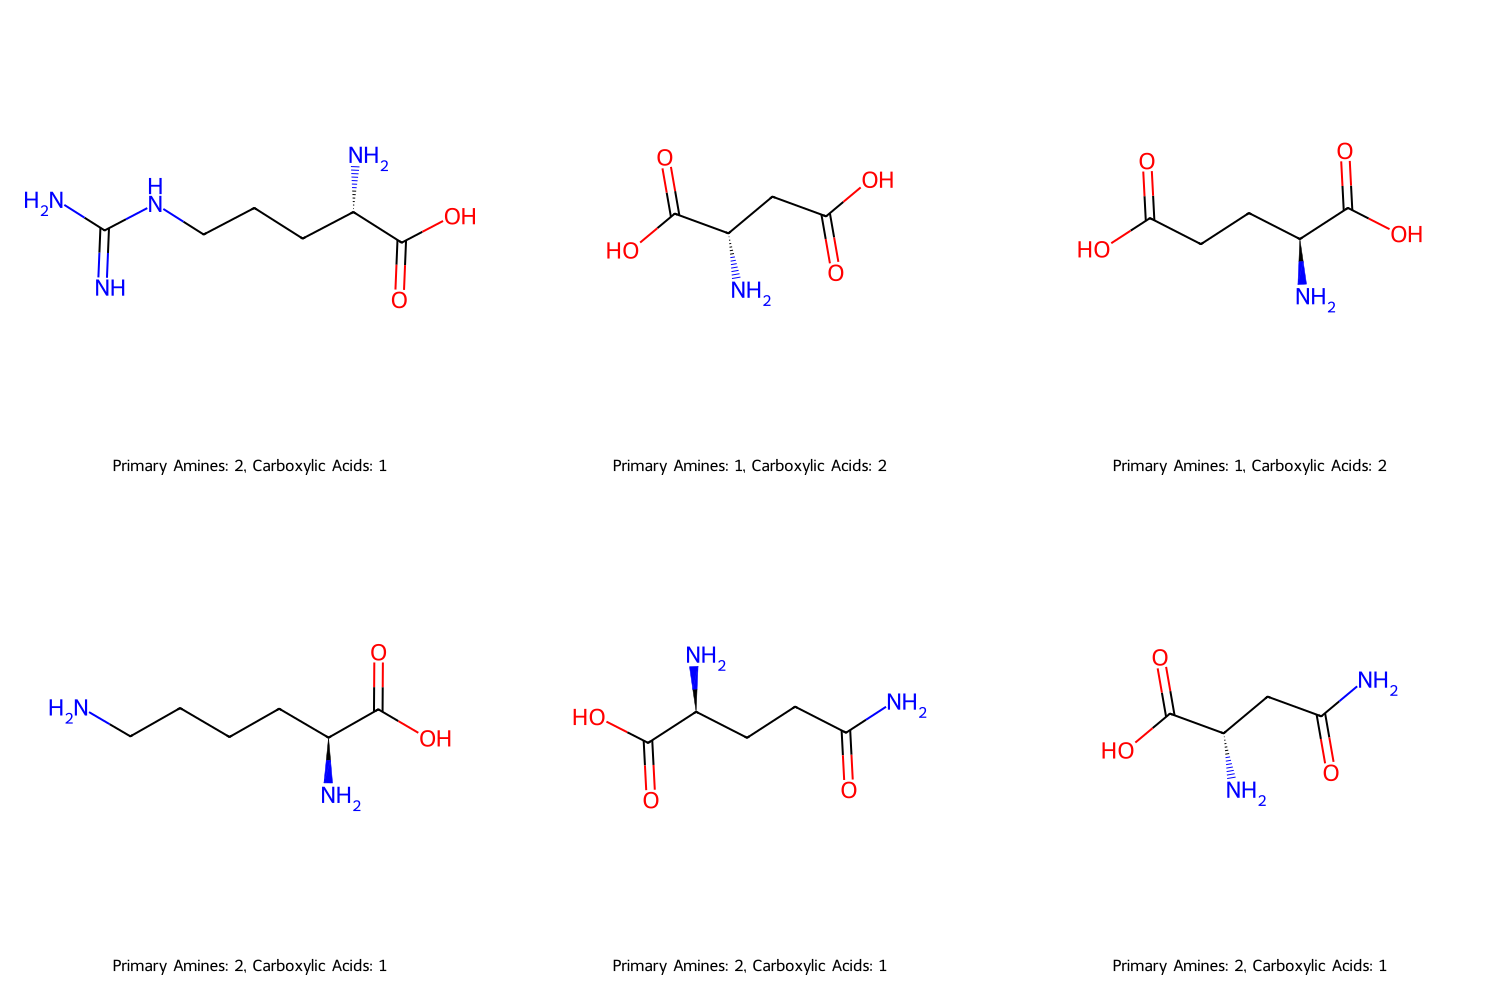

In [11]:
# Visualize the amino acids with issues
amino_acids_mols_issue = [Chem.MolFromSmiles(smiles) for smiles in df_amino_acids_issue["SMILES"]]
Draw.MolsToGridImage(amino_acids_mols_issue, molsPerRow=3, subImgSize=(500, 500), legends=[f"Primary Amines: {row['Primary Amines']}, Carboxylic Acids: {row['Carboxylic Acids']}" for index, row in df_amino_acids_issue.iterrows()])

In [12]:
# Filter out the amino acids with issues
df_amino_acids = df_amino_acids[~df_amino_acids["SMILES"].isin(df_amino_acids_issue["SMILES"])]
amino_acids_no_FMOC = df_amino_acids["SMILES"].tolist() # Update the list of amino acids

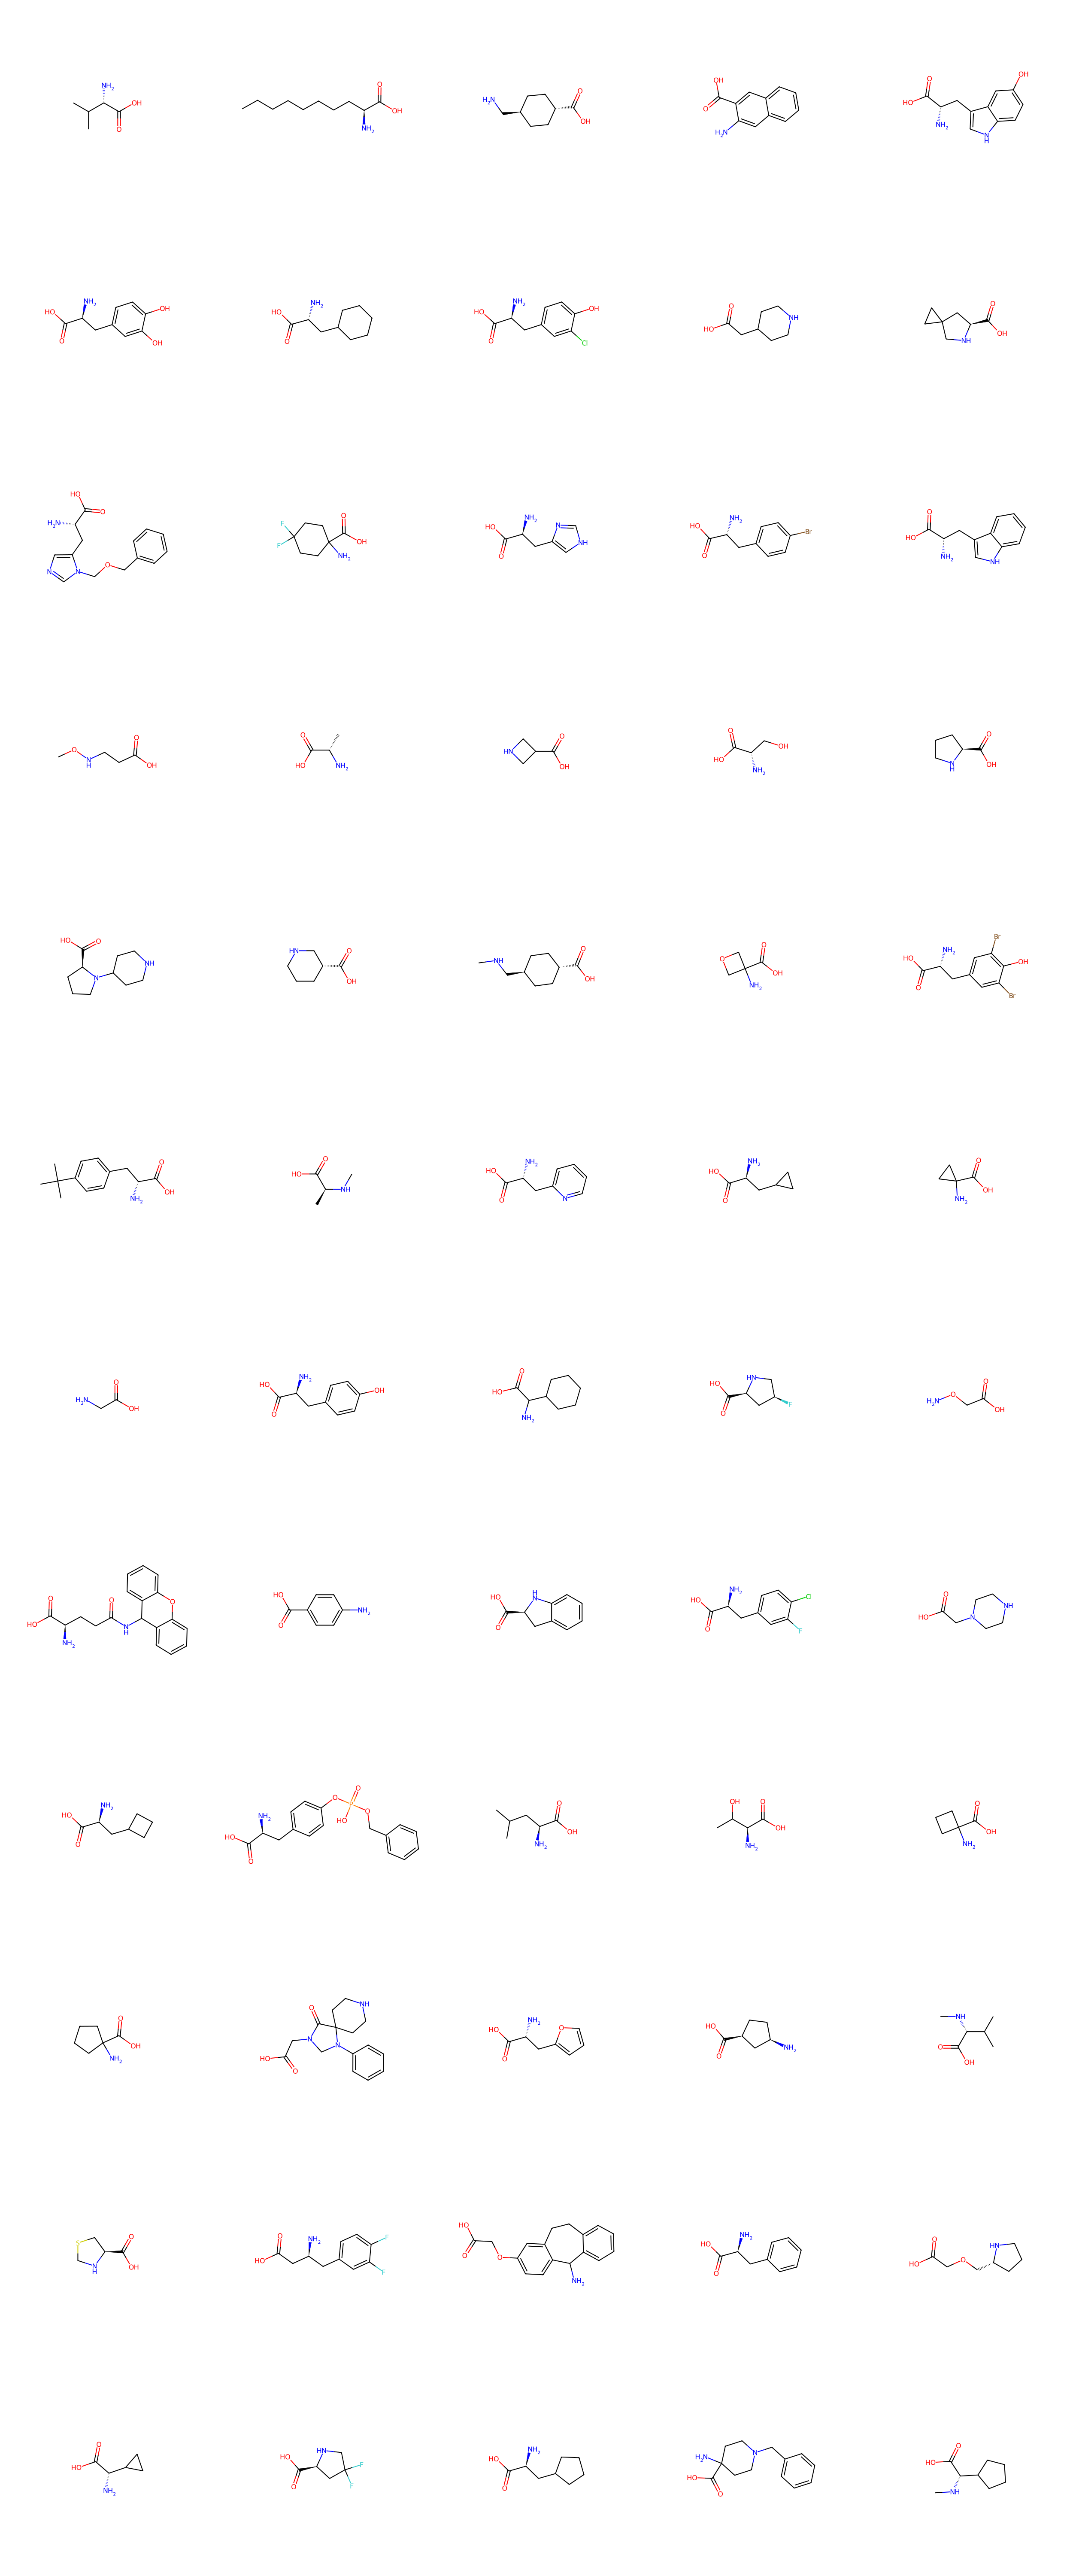

In [13]:
# Visualize all the amino acid structures
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in amino_acids_no_FMOC],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

### Rotatable Bonds Filter
Filters out Amino acids based on the number of rotatable bonds

In [14]:
# Rotatable Bonds analysis
amino_acids_no_FMOC_rotatable_bonds = []
for mol in amino_acids_no_FMOC:
    molecule = Chem.MolFromSmiles(mol)
    rotatable_bonds = rdMolDescriptors.CalcNumRotatableBonds(molecule)
    amino_acids_no_FMOC_rotatable_bonds.append(rotatable_bonds)

In [15]:
# Create a DataFrame
df_amino_acids_no_FMOC = pd.DataFrame({
    'SMILES': amino_acids_no_FMOC,
    'Rotatable Bonds': amino_acids_no_FMOC_rotatable_bonds
})

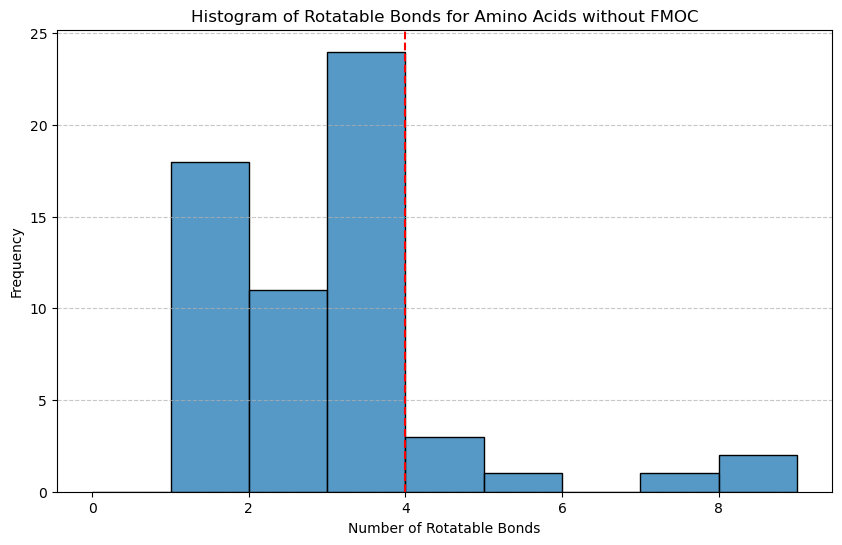

In [16]:
# Generate a histogram of the rotatable bonds
threshold = 4
plt.figure(figsize=(10, 6))
sns.histplot(df_amino_acids_no_FMOC['Rotatable Bonds'], bins=range(df_amino_acids_no_FMOC['Rotatable Bonds'].max() + 2), kde=False)
plt.axvline(threshold, color='r', linestyle='--')
plt.title('Histogram of Rotatable Bonds for Amino Acids without FMOC')
plt.xlabel('Number of Rotatable Bonds')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

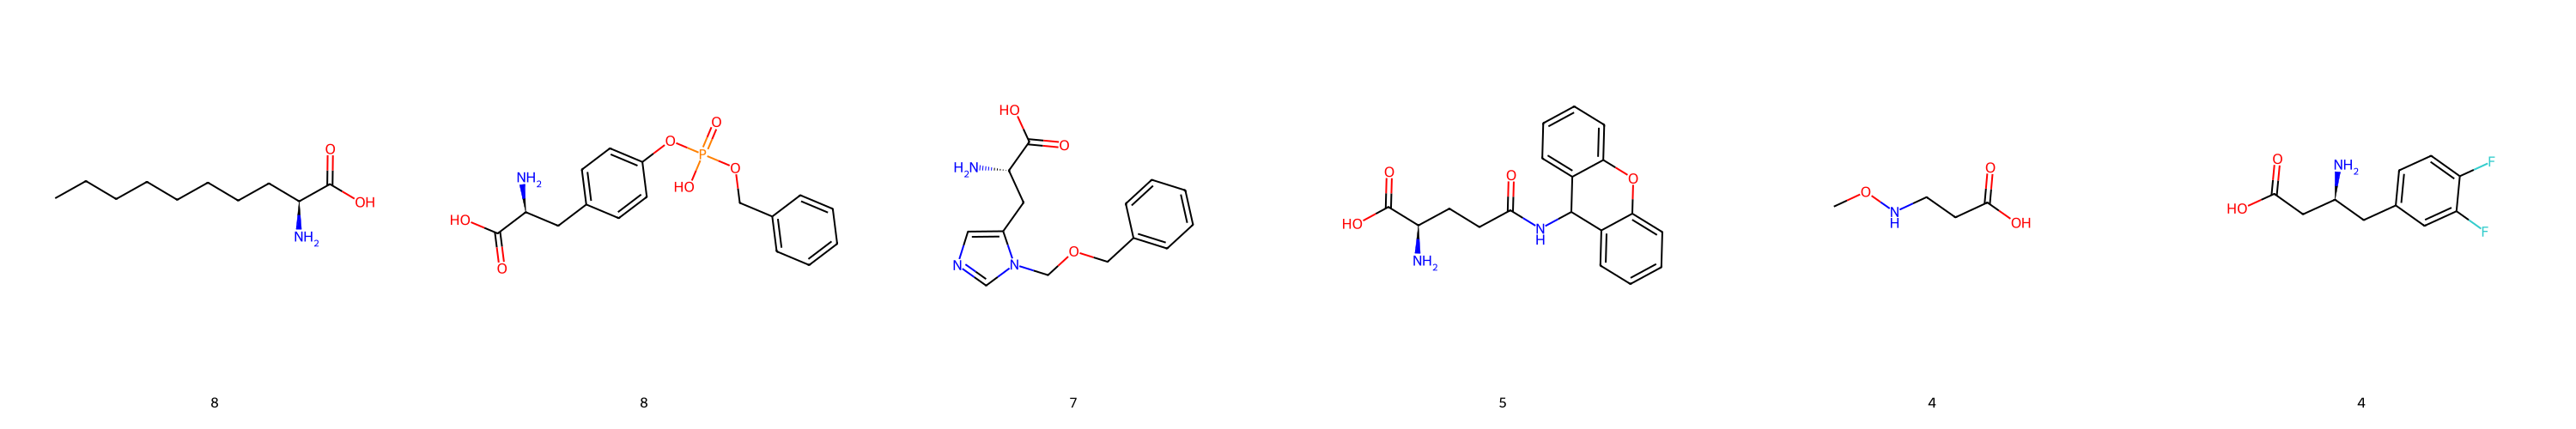

In [17]:
# Visualize top 6 amino acids with the most number of rotational bonds
top_6_amino_acids = df_amino_acids_no_FMOC.nlargest(6, 'Rotatable Bonds')
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in top_6_amino_acids['SMILES']], molsPerRow=6, subImgSize=(500, 500), legends=[str(x) for x in top_6_amino_acids['Rotatable Bonds']])

In [18]:
# Remove top 6 amino acids with the most number of rotational bonds from the original list
# This is important since it modifies the list of amino acids, I am eliminating any amino acid that has more than 4 rotatable bonds

# Filter out the top 6 from the original list
filtered_amino_acids_no_FMOC = df_amino_acids_no_FMOC[~df_amino_acids_no_FMOC['SMILES'].isin(top_6_amino_acids['SMILES'])]

# Update the list
amino_acids_no_FMOC = filtered_amino_acids_no_FMOC['SMILES'].tolist()

In [19]:
# Write the filtered amino acids to a .smi file
with open('./Data/M_pro/filtered_amino_acids.smi', 'w') as file:
    for smiles in amino_acids_no_FMOC:
        file.write(f"{smiles}\n")

### Amino acids Library members
Please take note that there are certain members with 3 ringed structures present which may look similar to Fmoc but are not Fmoc (See structure no. 25). 

### Primary Amine Amino Acids Library Members
We need to find amino acids with terminal primary amines since these will be coupling site for the aldehyde. Lets screen the amino acids for those members with terminal primary amines.

*Note: The original list of amino acids has been modified to not include any amino acids with more than 4 rotatable bonds* 

In [20]:
# Load Filtered Amino Acids
# This is a sanity check to ensure that the filtered amino acids are loaded correctly
filtered_amino_acids = []
with open('./Data/M_pro/filtered_amino_acids.smi') as f:
    for mol in f:
        filtered_amino_acids.append(mol)

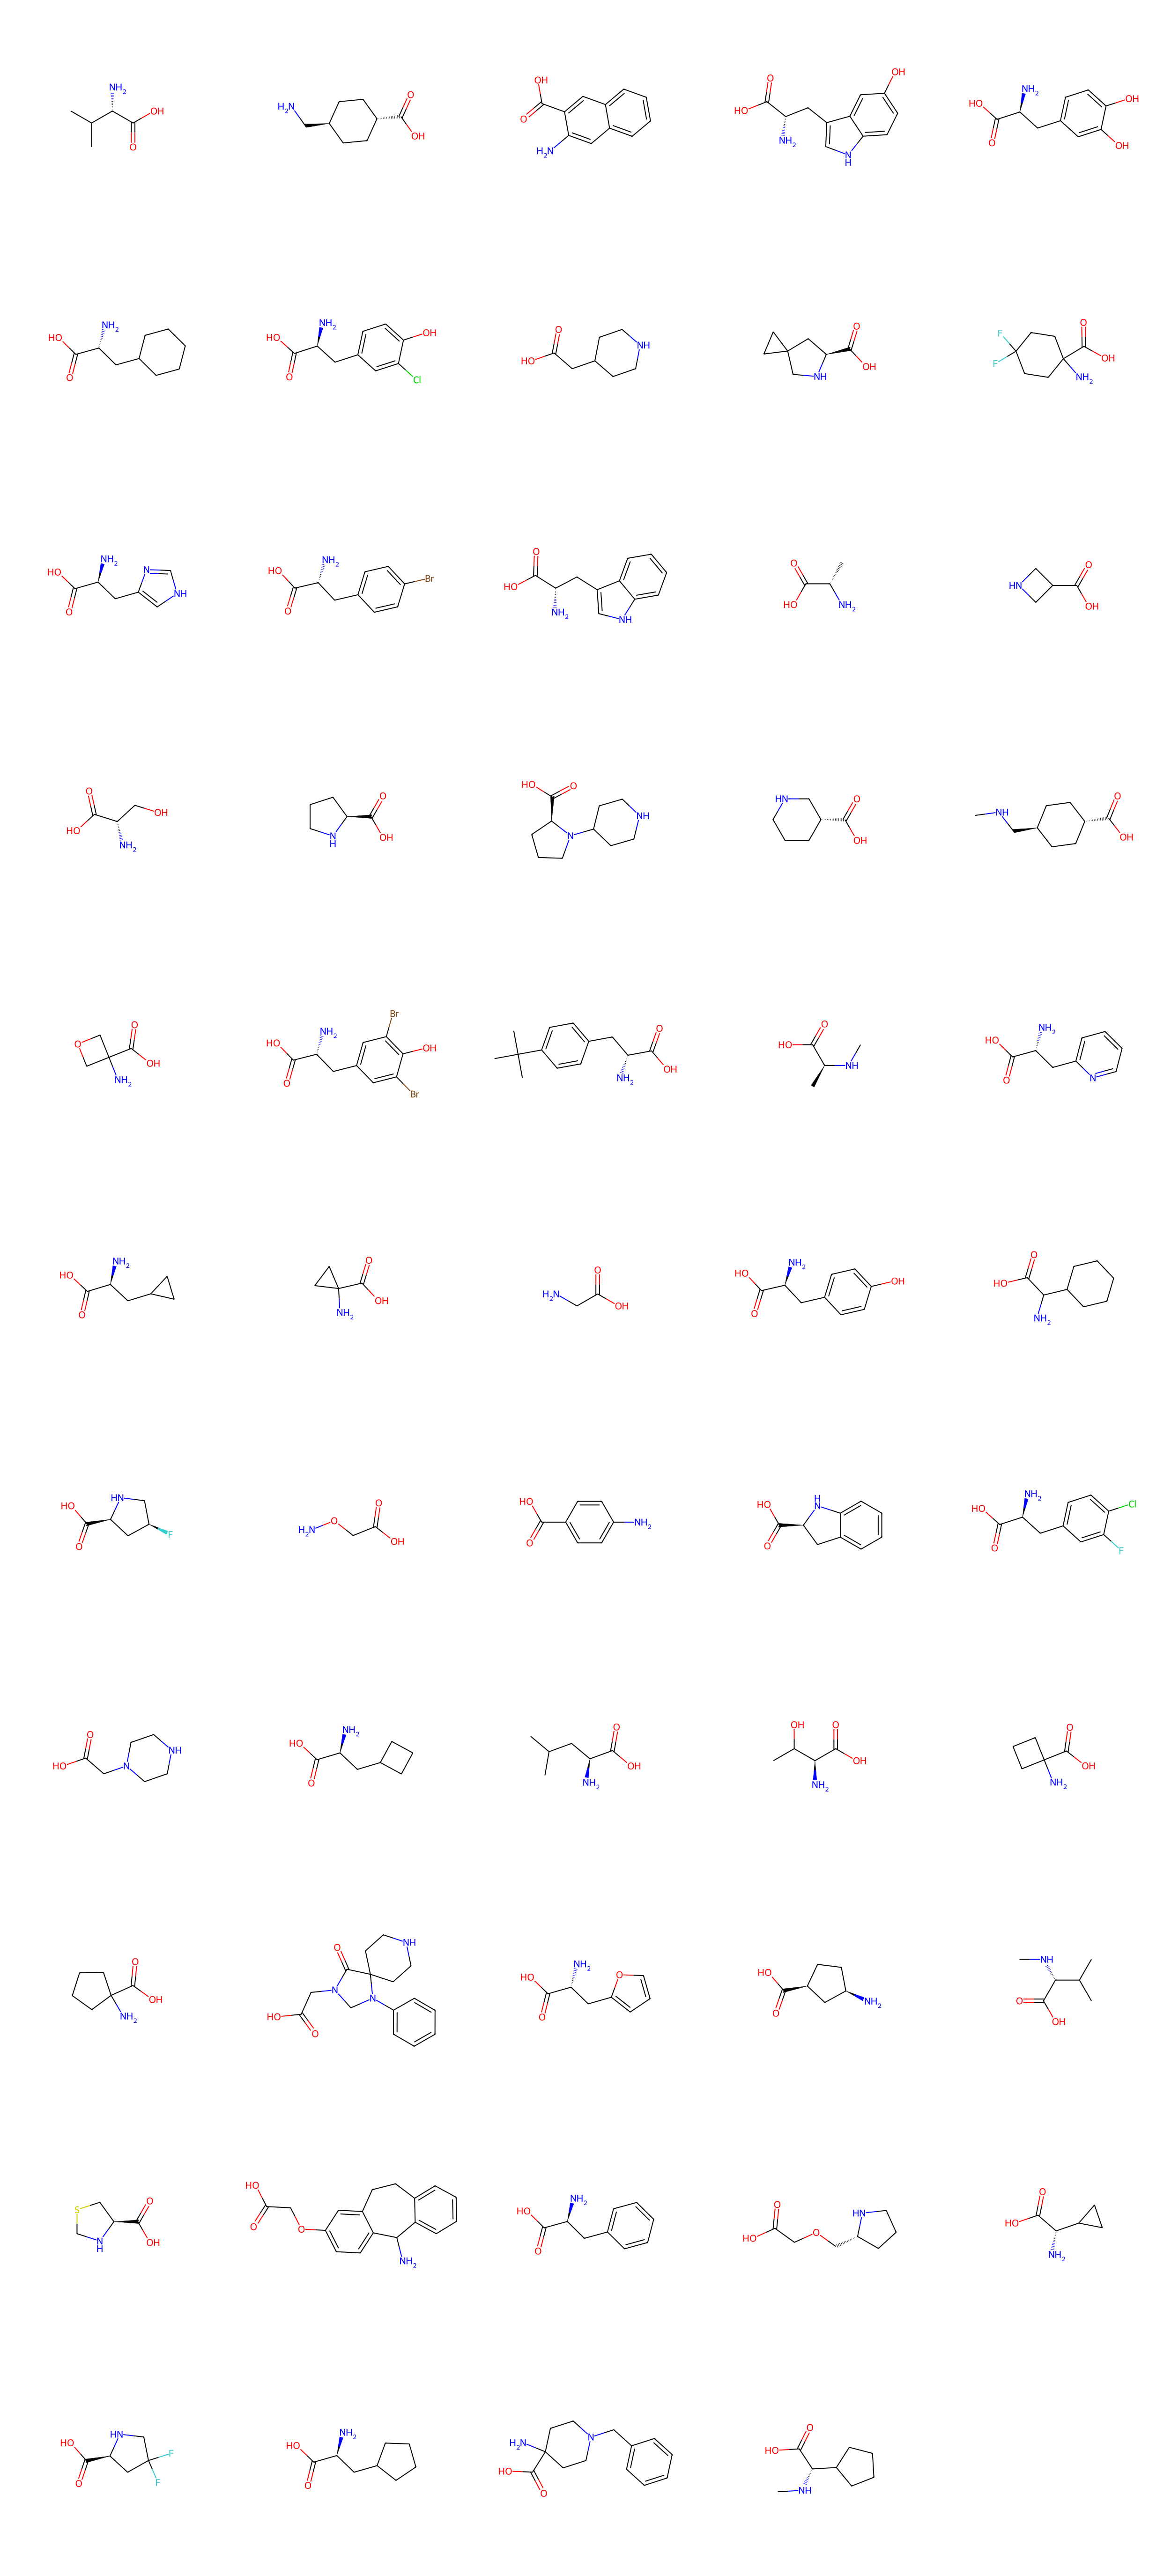

In [21]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in filtered_amino_acids],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

In [22]:
primary_amines, no_primary_amines = check_substructure(filtered_amino_acids,"[#7X3;H2]")

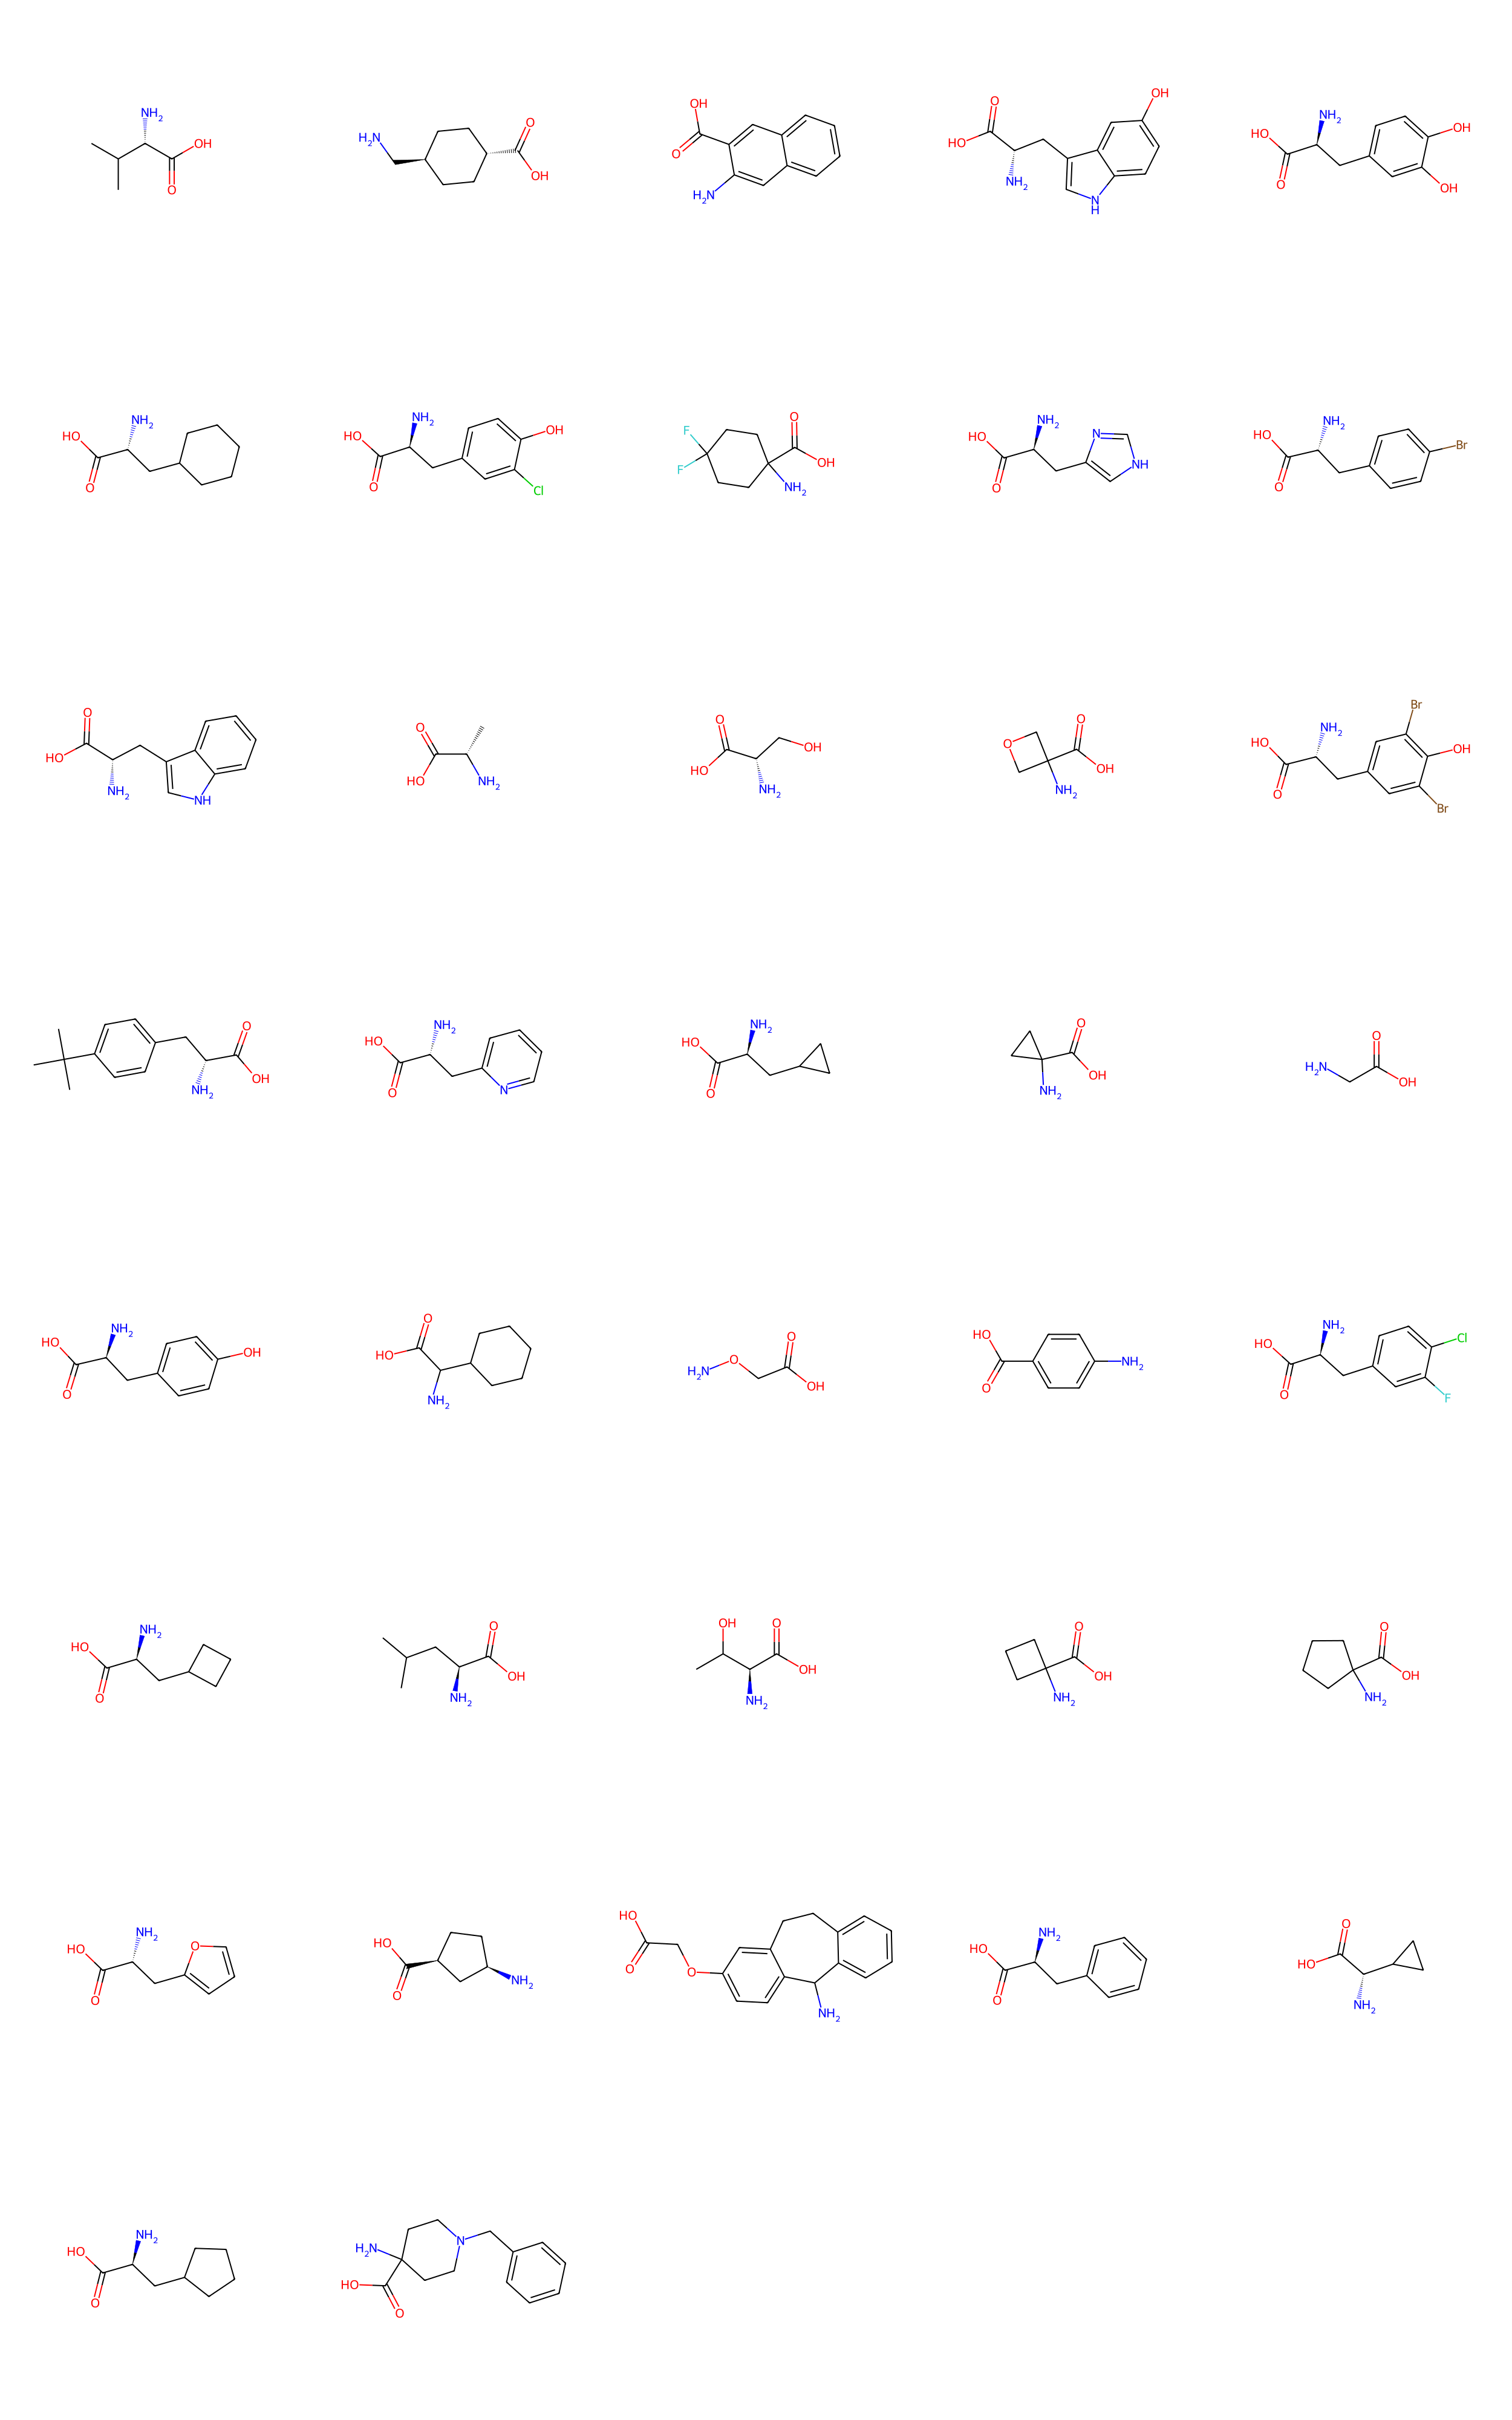

In [23]:
# Visualize Amino Acids with a primary amine
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in primary_amines],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

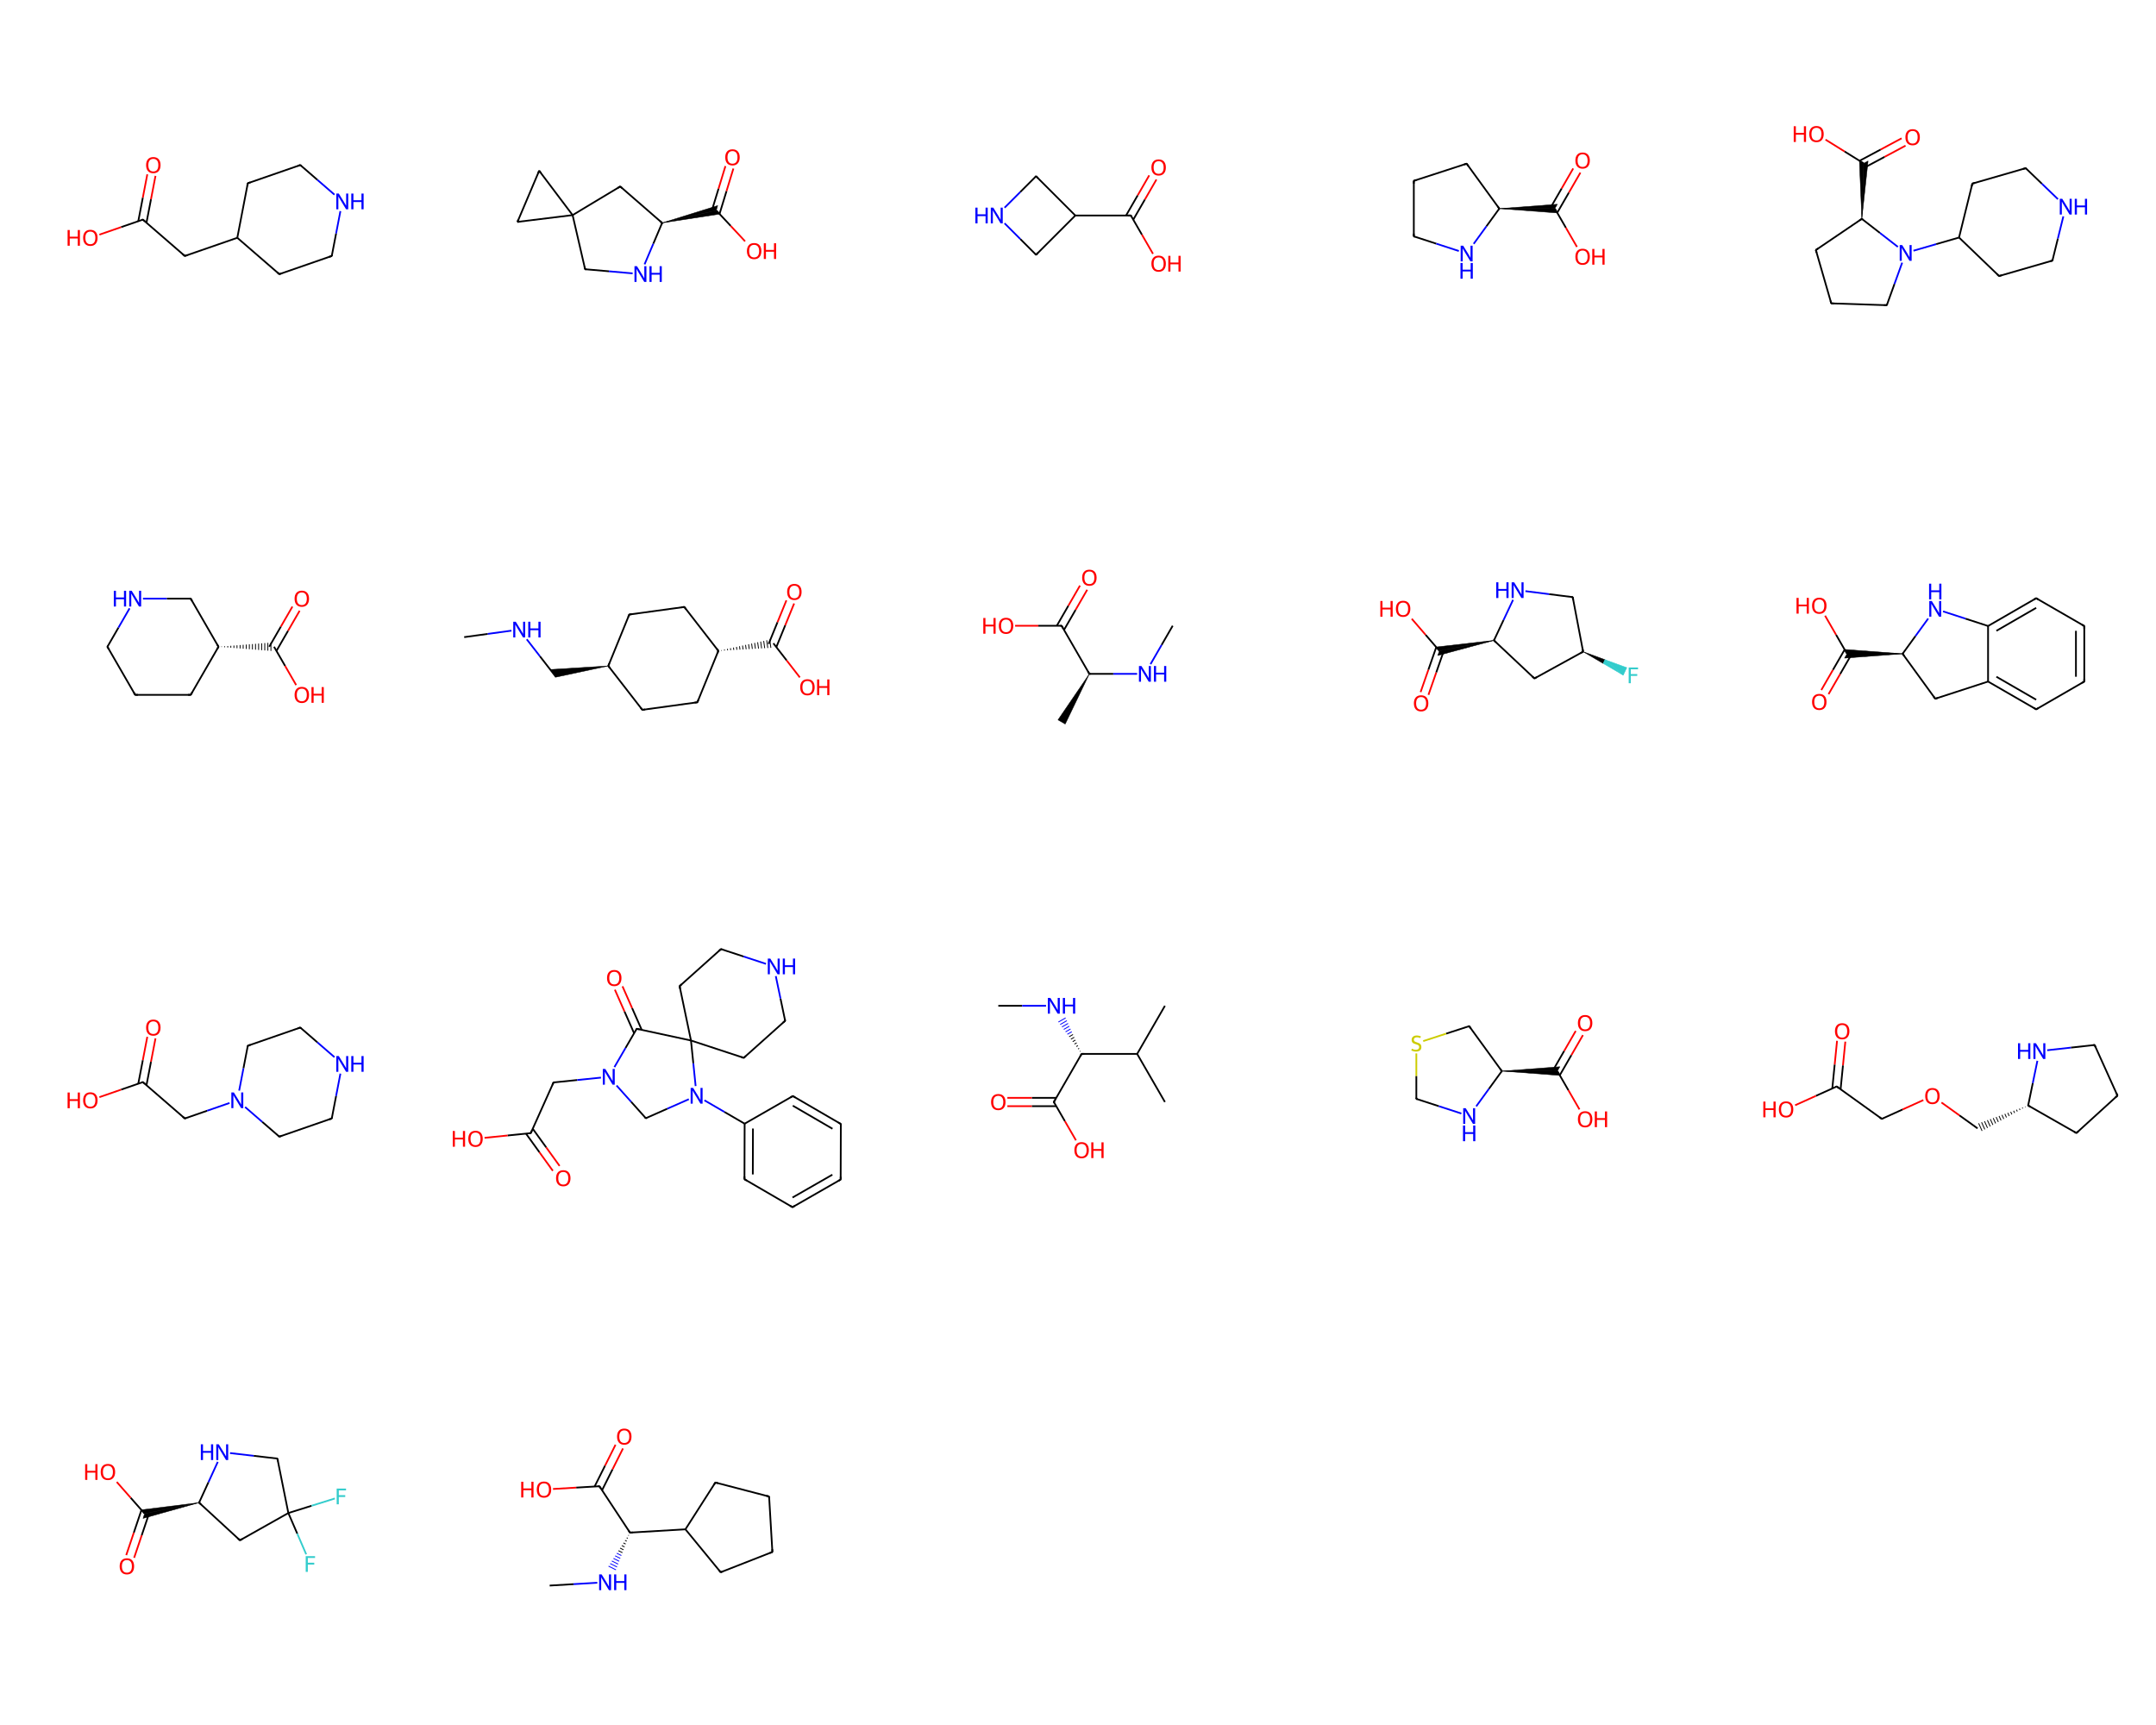

In [24]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in no_primary_amines],molsPerRow=5, subImgSize=(500, 500),maxMols=70)

In [25]:
# Write these amino acids with terminal primary amines to a new file
with open('./Data/M_pro/primary_amines_aa.smi', 'w') as w:
	for mol in primary_amines:
		w.write(f"{mol}")

### Amino Acid Coupling
We are defining the reaction to couple two amino acids here. Note that the primary amines are one set of reactants and the other is the list of all amines (primary and secondary) since amino acids can be coupled together.

In [26]:
rxn  = AllChem.ReactionFromSmarts("[#6:1](=O)[OH].[#7X3;!H0:2]>>[#7:2][#6:1]=[O]")
# rxn = AllChem.ReactionFromSmarts("[H][C]([#6:1](=O)[OH])[N].[H][C](C(=O)[OH])[#7:2]>>[#6:1](=O)[#7:2]")
# The second reaction SMARTS is not able to identify a substructure in the amino acids and hence I cannot couple the amino acids

**Reaction SMARTS for Amino Acid coupling**

The reaction SMARTS pattern does not identify specifically the substructures needed to perform the reaction.

In [27]:
# Convert amino acid SMILES to rdkit mol objects
aa_mols = [Chem.MolFromSmiles(x) for x in filtered_amino_acids]
primary_amines_mols = [Chem.MolFromSmiles(x) for x in primary_amines]

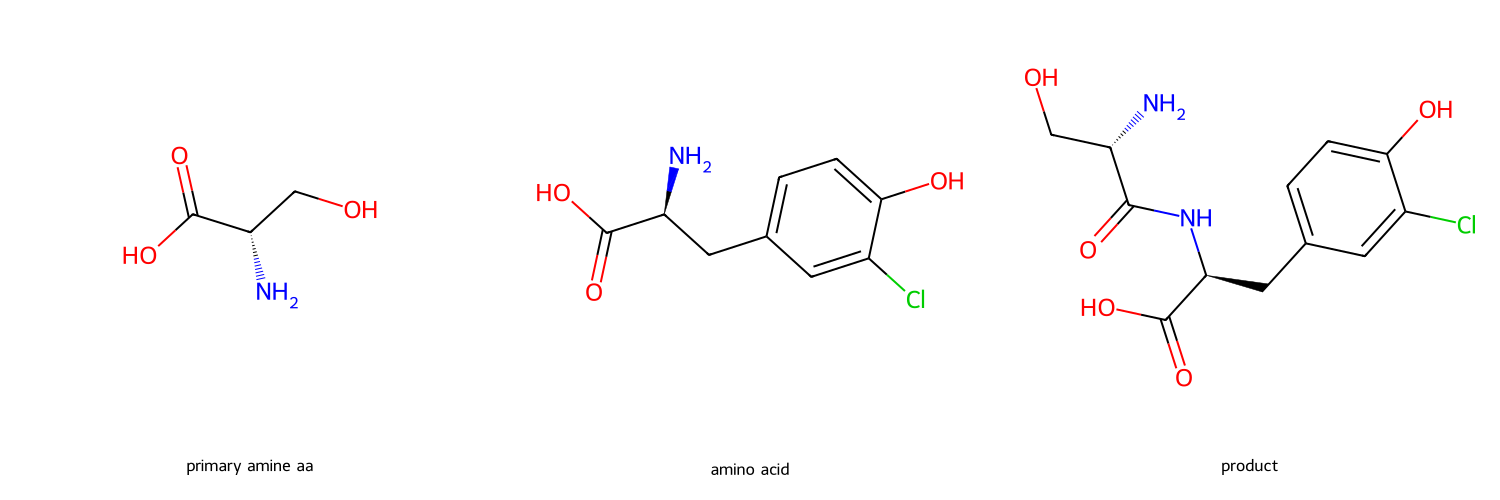

In [28]:
# Lets Test Some of the  Reactants to make sure the product is as expected
test_prod = rxn.RunReactants((primary_amines_mols[12],aa_mols[6]))[0][0]
Chem.Draw.MolsToGridImage([primary_amines_mols[12],aa_mols[6], test_prod],molsPerRow=3, subImgSize=(500, 500), legends=["primary amine aa", "amino acid", "product"])

In [29]:
# Run amino acid coupling reaction
coupled_aa_mols = [rxn.RunReactants((x,y))[0][0] for x in tqdm.tqdm(primary_amines_mols) for y in aa_mols]
coupled_aa_SMILES = [Chem.MolToSmiles(x) for x in tqdm.tqdm(coupled_aa_mols)]
print("total no. of products %.f" %len(coupled_aa_mols))

100%|██████████| 1998/1998 [00:00<00:00, 24492.25it/s]

total no. of products 1998


In [30]:
# Check whether the products contain a primary amine
# If each molecule has a primary amine then the list for not selected molecules should be empty
coupled_aa_sel, coupled_aa_not_sel = check_substructure(coupled_aa_SMILES,"[#7X3;H2]")
print("Length of not 'selected amino acids list' " + str(len(coupled_aa_not_sel)))

Length of not 'selected amino acids list' 0


In [31]:
# Write the SMILES from the coupled amino acids to a text file 
with open('./Data/M_pro/input_files/coupled_aa.smi', 'w') as w:
	for number,mol in enumerate(coupled_aa_SMILES):
		reagent_no = 10000+number
		w.write(f"{mol}")
		w.write(" ")
		w.write('%d' % reagent_no) # Name of the building block
		w.write(os.linesep)

### Substitute Primary Amine with Hydroxyl 

In [32]:
amino_acids_coupled = pd.read_csv('./Data/M_pro/input_files/coupled_aa.smi', sep=' ', header=None, names=['SMILES', 'Reagent_No'])

[13:37:47] reactant 1 has no mapped atoms.


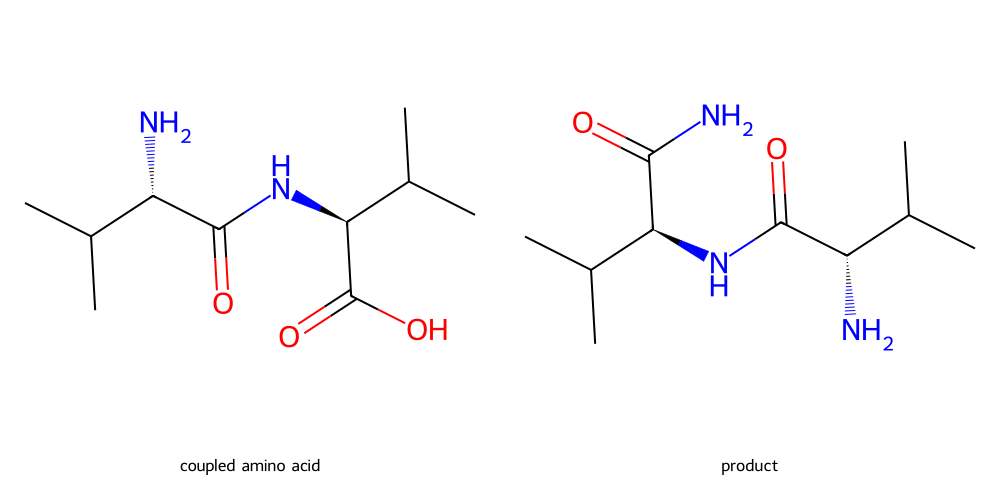

In [34]:
# SMARTS pattern for primary amine NOT connected to a carbonyl - [NH2;!$(NC=O)]
test_coupled_aa = amino_acids_coupled['SMILES'][0]
rxn_amine_linker = AllChem.ReactionFromSmarts("[#6:1](=O)[OH].[NH2]>>[#6:1](=O)[NH2]")
test_coupled_aa_mol = Chem.MolFromSmiles(test_coupled_aa)
priamry_amine = Chem.MolFromSmarts("[NH2]")
mod_coupled_aa = rxn_amine_linker.RunReactants((test_coupled_aa_mol,priamry_amine))[0][0]
Chem.Draw.MolsToGridImage([test_coupled_aa_mol, mod_coupled_aa],molsPerRow=2, subImgSize=(500, 500), legends=["coupled amino acid", "product"])

In [35]:
# Lets perform the Primary amine substitution on all the coupled amino acids
rxn_amine_linker = AllChem.ReactionFromSmarts("[#6:1](=O)[OH].[NH2:2]>>[#6:1](=O)[NH2:2]")
mod_coupled_aa_list = []
for coupled_amino_acid in amino_acids_coupled['SMILES']:
    mol = Chem.MolFromSmiles(coupled_amino_acid)
    primary_amine = Chem.MolFromSmarts("[NH2]")
    if mol:
        mod_coupled_aa = rxn_amine_linker.RunReactants((mol,primary_amine))[0][0]
        mod_coupled_aa_list.append(Chem.MolToSmiles(mod_coupled_aa))

In [36]:
coupled_aa_acid_sel, coupled_aa_acid_not_sel = check_substructure(amino_acids_coupled['SMILES'],"[#6](=O)[OH]")

In [37]:
# Check whether the primary amine for reductive amination can be detected
mod_coupled_aa_sel, mod_coupled_aa_not_sel = check_substructure(mod_coupled_aa_list,"[NH2;!$(NC=O)]")
print("Length of not 'selected modified amino acids list' " + str(len(mod_coupled_aa_not_sel)))

Length of not 'selected modified amino acids list' 0


In [38]:
# Write the SMILES from the modified coupled amino acids to a text file 
with open('./Data/M_pro/input_files/mod_coupled_aa.smi', 'w') as w:
	for number,mol in enumerate(mod_coupled_aa_list):
		reagent_no = 10000+number
		w.write(f"{mol}")
		w.write(" ")
		w.write('%d' % reagent_no) # Name of the building block
		w.write(os.linesep)

## Reductive Amination with Aldehyde

### Preparing Aldehyde and Carboxylic acid data
These files will need to be reformatted with names for each of the building blocks.

In [39]:
# First read the files provided
# aldehyde building blocks
aldehydes = []
with open('./Data/M_pro/aldehydes.smi') as f1:
	for mol in f1:
		aldehydes.append(mol.rstrip('\n'))

In [40]:
# Check for duplicates and standardize the SMILES
aldehydes = standardize_and_remove_duplicates(aldehydes)

In [41]:
# Count the number of carbonyl groups in each aldehyde
aldehydes_counts = count_functional_group_occurrences(aldehydes, "[#6](=O)")

In [42]:
# There are some molecules with more than one carbonyl group
print(aldehydes_counts[(aldehydes_counts['Occurrences'] != 1)])

                              SMILES  Occurrences
5                          CC(=O)C=O            2
35                       O.O=CC(=O)O            2
46  O=CCNC(=O)OCC1c2ccccc2-c2ccccc21            2


In [43]:
# Filter out the aldehydes with more than one carbonyl group
aldehydes_filtered = aldehydes_counts[aldehydes_counts['Occurrences'] == 1]['SMILES'].tolist()

In [44]:
# Read carboxylic acid building blocks
acids = []
with open('./Data/M_pro/carboxylic_acids.smi') as f2:
	for mol in f2:
		acids.append(mol.rstrip('\n'))

In [45]:
# Check for duplicates and standardize the SMILES
acids = standardize_and_remove_duplicates(acids)

In [46]:
# Count the number of carboxylic acids for each molecule
carboxylic_acid_counts = count_functional_group_occurrences(acids, "[#6](=O)[OH]")


In [47]:
# There are some compounds with no carboxylic acids
print(carboxylic_acid_counts[(carboxylic_acid_counts["Occurrences"] != 1)])

                                                SMILES  Occurrences
62                O=C([O-])c1nc(=O)[nH]c(=O)[nH]1.[K+]            0
115  CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...            0
118                          CCCCCCCCCCCC(=O)[O-].[K+]            0
184                             O=C([O-])c1ccccc1.[K+]            0
191                               C[N+](C)(C)C.O=C[O-]            0
208                             O=C([O-])c1cccs1.[Cu+]            0


In [48]:
# Filter out the carboxylic acids with no carboxylic acids
acids_filtered = carboxylic_acid_counts[carboxylic_acid_counts["Occurrences"] == 1]["SMILES"].tolist()

In [49]:
# Write them into new input files that contain names
with open('./Data/M_pro/input_files/aldehydes_input.smi','w') as w2:
	for number, mol in enumerate(aldehydes_filtered):
		reagent_no = 2000+number
		w2.write(f"{mol}")
		w2.write(" ")
		w2.write('%d' % reagent_no)
		w2.write(os.linesep)

In [50]:
with open('./Data/M_pro/input_files/acids_input.smi','w') as w4:
	for number, mol in enumerate(acids_filtered):
		reagent_no = 3000+number
		w4.write(f"{mol}")
		w4.write(" ")
		w4.write('%d' % reagent_no)
		w4.write(os.linesep)

#### Modified input files
Please see analysis above, standardized the SMILES to remove any duplicates and use only canonical SMILES. Also checked to see whether there were any compounds that contained more or less than 1 functional group for each building block list. Those were removed and the input files were modified accordingly. 

## Load Input Files 

In [52]:
aldehydes_input = pd.read_csv('./Data/M_pro/input_files/aldehydes_input.smi', sep=" ", header=None, names=["SMILES", "reagent_no"])
acids_input = pd.read_csv('./Data/M_pro/input_files/acids_input.smi', sep=" ", header=None, names=["SMILES", "reagent_no"])
coupled_aa_input = pd.read_csv('./Data/M_pro/input_files/mod_coupled_aa.smi', sep=" ", header=None, names=["SMILES", "reagent_no"])

## Rotatable Bond based filtering
Generate a histogram of the number of rotatable bonds per building block.

In [53]:
# First lets calculate the number of rotatable bonds for each building block
coupled_aa_mols = [Chem.MolFromSmiles(x) for x in coupled_aa_input["SMILES"]]
aldehydes_mols = [Chem.MolFromSmiles(x) for x in aldehydes_input["SMILES"]]
acids_mols = [Chem.MolFromSmiles(x) for x in acids_input["SMILES"]]
rotatable_bonds_aa = [Chem.rdMolDescriptors.CalcNumRotatableBonds(x) for x in coupled_aa_mols]
rotatable_bonds_aldehydes = [Chem.rdMolDescriptors.CalcNumRotatableBonds(x) for x in aldehydes_mols]
rotatable_bonds_acids = [Chem.rdMolDescriptors.CalcNumRotatableBonds(x) for x in acids_mols]

In [54]:
# Add rotatable bonds to dataframes
aldehydes_input["Rotatable Bonds"] = rotatable_bonds_aldehydes
acids_input["Rotatable Bonds"] = rotatable_bonds_acids
coupled_aa_input["Rotatable Bonds"] = rotatable_bonds_aa

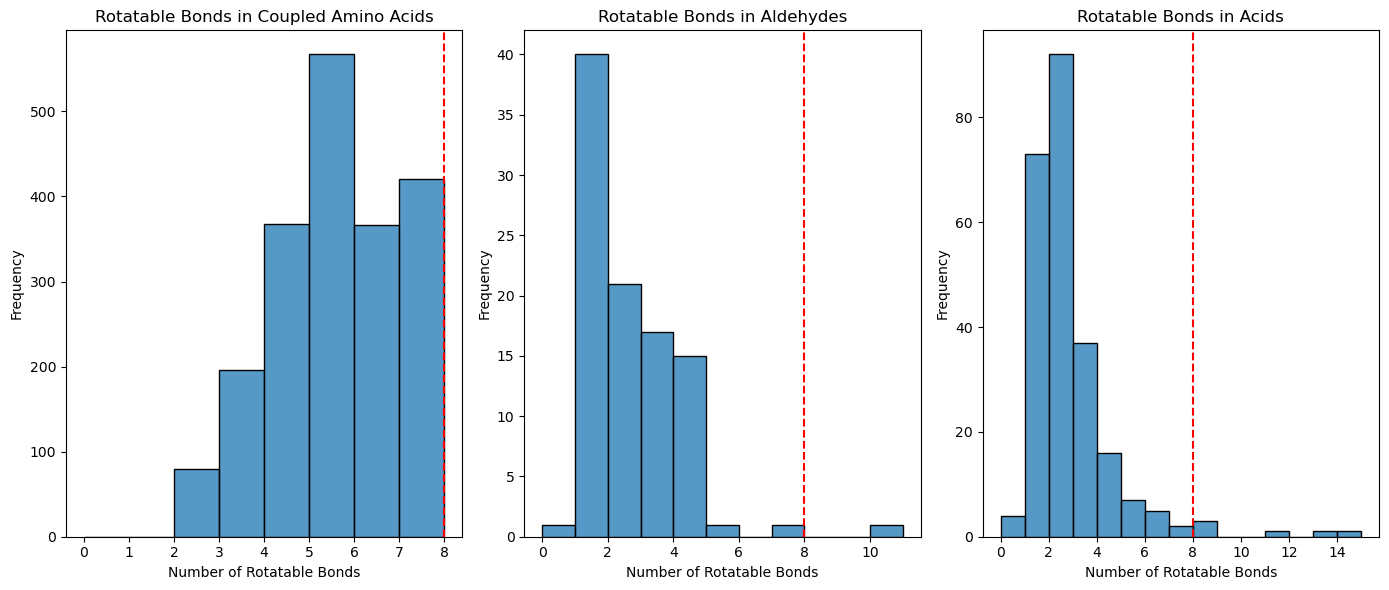

In [55]:
# Define the threshold value
threshold = 8

# Create a histogram for each dataframe
plt.figure(figsize=(14, 6))

# Histogram for coupled amino acids
plt.subplot(1, 3, 1)
sns.histplot(coupled_aa_input['Rotatable Bonds'], bins=range(coupled_aa_input['Rotatable Bonds'].max() + 2), kde=False)
plt.axvline(threshold, color='r', linestyle='--')
plt.title('Rotatable Bonds in Coupled Amino Acids')
plt.xlabel('Number of Rotatable Bonds')
plt.ylabel('Frequency')

# Histogram for aldehydes
plt.subplot(1, 3, 2)
sns.histplot(aldehydes_input['Rotatable Bonds'], bins=range(aldehydes_input['Rotatable Bonds'].max() + 2), kde=False)
plt.axvline(threshold, color='r', linestyle='--')
plt.title('Rotatable Bonds in Aldehydes')
plt.xlabel('Number of Rotatable Bonds')
plt.ylabel('Frequency')

# Histogram for acids
plt.subplot(1, 3, 3)
sns.histplot(acids_input['Rotatable Bonds'], bins=range(acids_input['Rotatable Bonds'].max() + 2), kde=False)
plt.axvline(threshold, color='r', linestyle='--')
plt.title('Rotatable Bonds in Acids')
plt.xlabel('Number of Rotatable Bonds')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Filter out building blocks with greater than 8 rotatable bonds

In [56]:
# Function to calculate rotatable bonds and filter molecules
def filter_molecules(df, threshold=8):
    filtered_smiles = []
    filtered_out_smiles = []
    for index, row in df.iterrows():
        smiles = row['SMILES']
        reagent_no = row['reagent_no']
        molecule = Chem.MolFromSmiles(smiles)
        if molecule:
            rotatable_bonds = rdMolDescriptors.CalcNumRotatableBonds(molecule)
            if rotatable_bonds < threshold:
                filtered_smiles.append(row)
            else:
                filtered_out_smiles.append(row)
    return pd.DataFrame(filtered_smiles), pd.DataFrame(filtered_out_smiles)


In [57]:
# Filter the dataframes
filtered_aldehydes, filtered_out_aldehydes = filter_molecules(aldehydes_input)
filtered_acids, filtered_out_acids = filter_molecules(acids_input)
filtered_coupled_aa, filtered_out_coupled_aa = filter_molecules(coupled_aa_input)

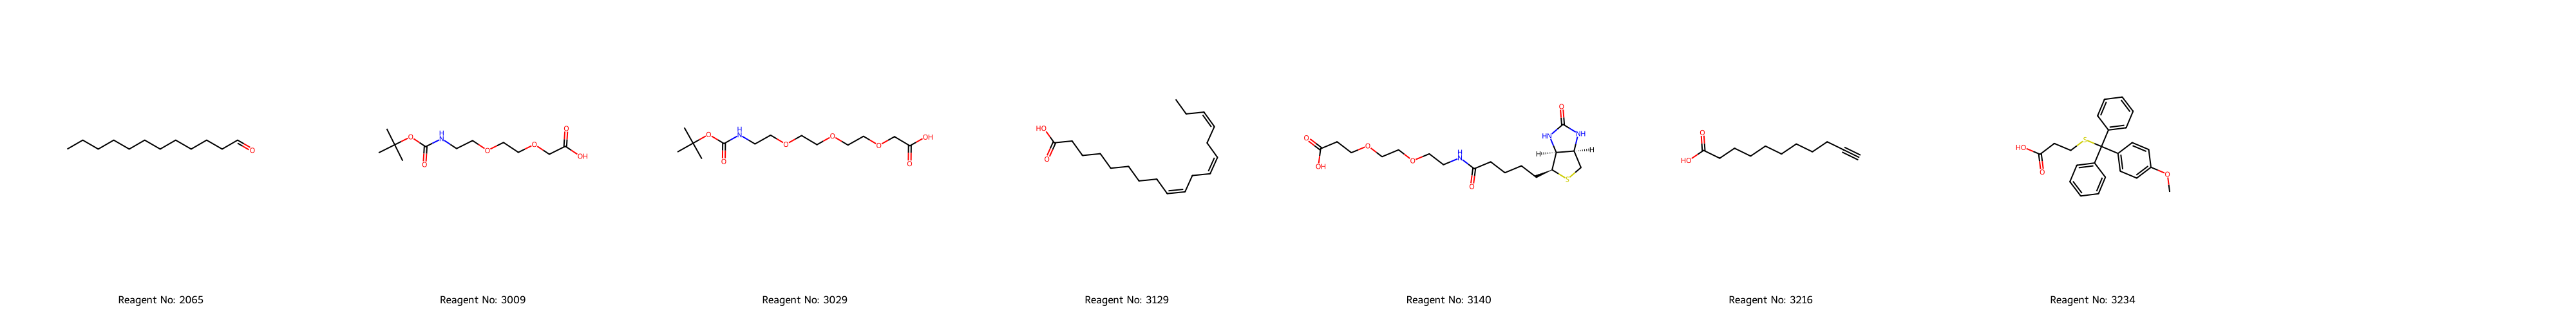

In [58]:
# Combine filtered out molecules for visualization
filtered_out_smiles = pd.concat([filtered_out_aldehydes, filtered_out_acids, filtered_out_coupled_aa])

# Visualize the filtered out molecules with legends
filtered_out_molecules = [Chem.MolFromSmiles(smiles) for smiles in filtered_out_smiles['SMILES']]
legends = [f"Reagent No: {reagent_no}" for reagent_no in filtered_out_smiles['reagent_no']]
Draw.MolsToGridImage(filtered_out_molecules, molsPerRow=8, subImgSize=(500, 500), legends=legends)

In [59]:
# Save the filtered dataframes back to their respective files
# Get rid of the rotatable bonds column
filtered_aldehydes.drop(columns='Rotatable Bonds', inplace=True)
filtered_acids.drop(columns='Rotatable Bonds', inplace=True)
filtered_coupled_aa.drop(columns='Rotatable Bonds', inplace=True)
# Write files to .smi format
filtered_aldehydes.to_csv('./Data/M_pro/input_files/aldehydes_input_filtered.smi', sep=" ", header=False, index=False)
filtered_acids.to_csv('./Data/M_pro/input_files/acids_input_filtered.smi', sep=" ", header=False, index=False)
filtered_coupled_aa.to_csv('./Data/M_pro/input_files/coupled_aa_filtered.smi', sep=" ", header=False, index=False)

# Generate Products-Reductive Amination with Amine substitution
This is to check whether the reaction SMARTS are producing the correct product.

In [60]:
# Load Building Block Files of Interest
coupled_amino_acids_df, coupled_aa_list = read_smi_file('./Data/M_pro/input_files/coupled_aa_filtered.smi')
aldehydes_df, aldehydes_list = read_smi_file('./Data/M_pro/input_files/aldehydes_input_filtered.smi')
acids_df, acids_list = read_smi_file('./Data/M_pro/input_files/acids_input_filtered.smi')

In [61]:
#Previous SMARTS Pattern - [#7X3;H2:1].[#6:2](=O).[#6:3](=O)[O]>>[#6:2][#7:1][#6:3](=O)
rxn2 = AllChem.ReactionFromSmarts('[#7H2;!$(NC=O):1].[#6:2](=O).[#6:3](=O)[O]>>[#6:2][#7:1][#6:3](=O)')

In [62]:
# Generate a test Molecule
aldehyde = Chem.MolFromSmiles(aldehydes_list[10])
acid = Chem.MolFromSmiles(acids_list[10])
aa_coupled = Chem.MolFromSmiles(coupled_aa_list[10])
prod_3mer = rxn2.RunReactants((aa_coupled, aldehyde, acid))[0][0]

In [95]:
acids_list[2]

'Cc1ccc(C(=O)O)cc1[N+](=O)[O-]'

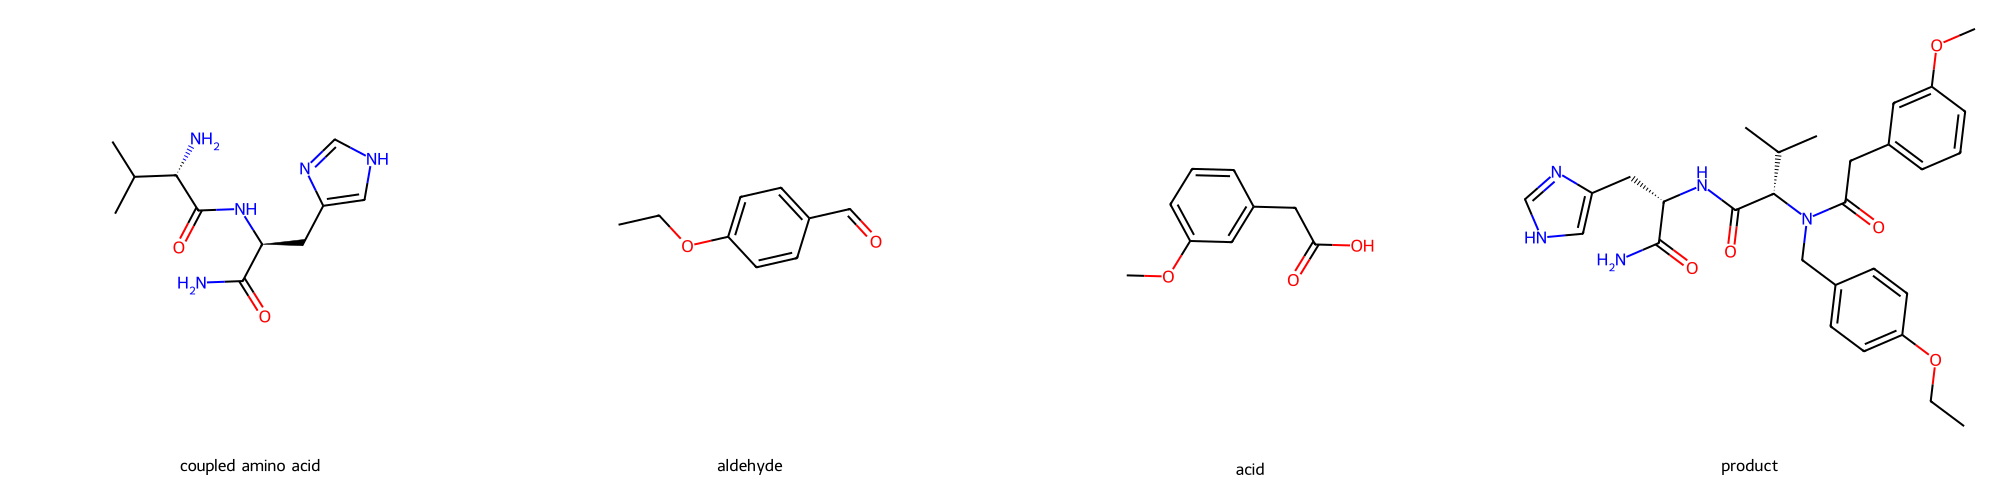

In [ ]:
# Visualize the test molecule
Chem.Draw.MolsToGridImage([aa_coupled, aldehyde, acid, prod_3mer],molsPerRow=4, subImgSize=(500, 500), legends=["coupled amino acid", "aldehyde", "acid", "product"])